In [2]:
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
import scipy

In [3]:
filepath = 'C:/Users/zlj01/Documents/Columbia University/GR5243/project 3/'
os.chdir(filepath)

trainpath = filepath + '/data/train_set/'

train_image_dir = trainpath + "images/"
train_pt_dir = trainpath + "points/"

In [4]:
import sklearn.metrics.pairwise
def pairwise_dist(vec):
    dist  = sklearn.metrics.pairwise_distances(vec, metric='euclidean')
    np.fill_diagonal(dist, np.nan)
    return dist
def feature(fiducial_pt_list,index):
    pairwise_dist_feature = pairwise_dist(fiducial_pt_list[index]).flatten()
    pairwise_dist_feature = pairwise_dist_feature[~np.isnan(pairwise_dist_feature)]
    return pairwise_dist_feature

f0 = time.time()
dataDir = train_pt_dir
fiducial_pt_list = []
filelist = []
for file in os.listdir(dataDir):
    filelist.append(file)
filelist.sort()
for file in filelist:
    fiducial_pt_list.append(scipy.io.loadmat(dataDir+file))
    l = []
for i in range(len(fiducial_pt_list)):
    if 'faceCoordinatesUnwarped' in fiducial_pt_list[i].keys():
        l.append(fiducial_pt_list[i]['faceCoordinatesUnwarped'])
    else:
        l.append(fiducial_pt_list[i]['faceCoordinates2'])
        
fiducial_pt_list = l

## Train / Test dataset split

In [5]:
X = pd.DataFrame(np.zeros((3000, 6006)))
for i in range(3000):
    X.iloc[i,:] = np.round(feature(fiducial_pt_list, i).flatten(), 0)
y =pd.read_csv(trainpath+'label.csv')['label']
f1 = time.time()-f0

train_x_dis,test_x_dis,train_y_dis,test_y_dis=train_test_split(X,y,test_size=0.2,random_state=123)
X_dis=X
y_dis=y

## Feature Scaling

In [6]:
sc = StandardScaler()

# Set the standard scaler by using the train set
train_x_dis = sc.fit_transform(train_x_dis)

# scale the testset based on the standard scaler of the train set
test_x_dis = sc.transform(test_x_dis)

## Deal with imbalance data

In [7]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(train_y_dis)
print(counter)



Counter({0: 1916, 1: 484})


### Oversampling using SMOTE

In [8]:
# transform the train dataset
oversample = SMOTE()
train_x_dis, train_y_dis = oversample.fit_resample(train_x_dis, train_y_dis)

# summarize the new class distribution
counter = Counter(train_y_dis)
print(counter)

Counter({1: 1916, 0: 1916})


## GridsearchCV to do hyperparameter tuning in the Random Forest

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf =RandomForestClassifier(n_estimators=100)
rf_gsearch = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

start_time=time.time()
rf_gsearch.fit(train_x_dis, train_y_dis)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

print(rf_gsearch.best_estimator_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.3min finished


training  model takes 259.191 seconds
RandomForestClassifier(max_depth=80, max_features=2, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=300)


In [11]:
from sklearn.metrics import accuracy_score
print("Training dataset Accuracy")
train_preds = rf_gsearch.predict(train_x_dis)
train_accuracy = accuracy_score(train_y_dis, train_preds) 
print(train_accuracy)

Training dataset Accuracy
0.9973903966597077


In [12]:
print("Testing dataset Accuracy")
test_preds = rf_gsearch.predict(test_x_dis)
test_accuracy = accuracy_score(test_y_dis, test_preds) 
print(test_accuracy)

Testing dataset Accuracy
0.805


## ROC Curve with AUC

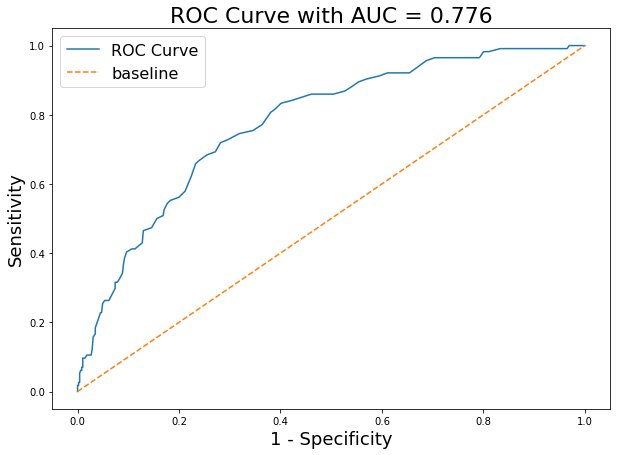

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

# Calculating class probabilities
pred_proba = [i[1] for i in rf_gsearch.predict_proba(test_x_dis)]
pred_df = pd.DataFrame({'true_values': test_y_dis,
                        'pred_probs':pred_proba})

# The codes below is motly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. 
thresholds = np.linspace(0, 1, 200)


# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(metrics.roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);